In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20    #多项式的最大阶数
n_train,n_test = 100,100    #训练和测试数据集大小
true_w = np.zeros(max_degree)    #分配大量空间
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train + n_test,1))
np.random.shuffle(features)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i + 1)    #gamma(n) = (n-1)!
#labels的维度：(n_train+n_test)
labels = np.dot(poly_features,true_w)
labels += np.random.normal(scale=0.1,size=labels.shape)

In [3]:
#numpy ndarray 转换为tensor
true_w,features,poly_features,labels = [torch.tensor(x,dtype = torch.float32) for x in [true_w,features,poly_features,labels]]

In [4]:
features[:2],poly_features[:2,:],labels[:2]

(tensor([[ 1.7285],
         [-0.1423]]),
 tensor([[ 1.0000e+00,  1.7285e+00,  1.4938e+00,  8.6065e-01,  3.7190e-01,
           1.2856e-01,  3.7036e-02,  9.1451e-03,  1.9759e-03,  3.7947e-04,
           6.5590e-05,  1.0306e-05,  1.4845e-06,  1.9738e-07,  2.4369e-08,
           2.8080e-09,  3.0335e-10,  3.0843e-11,  2.9617e-12,  2.6943e-13],
         [ 1.0000e+00, -1.4231e-01,  1.0126e-02, -4.8033e-04,  1.7089e-05,
          -4.8637e-07,  1.1536e-08, -2.3452e-10,  4.1717e-12, -6.5963e-14,
           9.3871e-16, -1.2144e-17,  1.4402e-19, -1.5765e-21,  1.6025e-23,
          -1.5203e-25,  1.3522e-27, -1.1320e-29,  8.9492e-32, -6.7029e-34]]),
 tensor([6.7625, 4.7384]))

In [5]:
def evaluate_loss(net,data_iter,loss):
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    #不设置偏置
    net = nn.Sequential(nn.Linear(input_shape,1,bias = False))
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
    print('weight:',net[0].weight.data.numpy())

三阶多项式函数拟合（正常）

weight: [[ 4.9912825  1.2887565 -3.3396208  5.343686 ]]


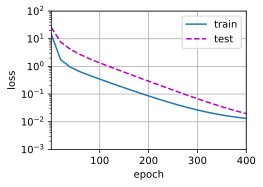

In [7]:
#从多项式特征中提取前4个维度
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])

线性函数拟合（欠拟合）

weight: [[3.740728 2.578718]]


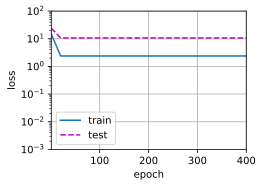

In [8]:
#从多项式特征中选取前两个维度
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

高阶多项式函数拟合（过拟合）

weight: [[ 5.033814    1.264655   -3.4660726   5.2142715   0.02048471  1.3885795
   0.09413236  0.3379257   0.20338978 -0.04495719 -0.17848636 -0.16895092
  -0.15645556  0.0375095   0.05165983 -0.12660529  0.21676493 -0.15376341
   0.04146314  0.14130166]]


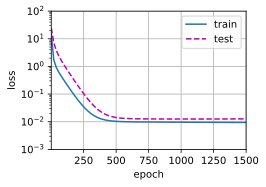

In [9]:
#从多项式特征中提取所有维度
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:],num_epochs=1500)

权重衰退（L2正则化）--限制特征的数量来缓解过拟合

In [16]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [17]:
#生成数据
n_train,n_test,num_inputs,batch_size = 20,100,200,5
true_w,true_b, = torch.ones((num_inputs,1)) * 0.01,0.05
train_data = d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data,batch_size)
test_data = d2l.synthetic_data(true_w,true_b,n_test)
test_iter = d2l.load_array(train_data,batch_size,is_train=False)

初始化模型

In [18]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

定义惩罚函数-L2范数惩罚

In [19]:
def l2_penalty(w):
    return torch.sum(w,pow(2)) / 2

In [38]:
#线性网络和平方损失未有发生变化，唯一的变化就是损失加入了惩罚项
def trian(lambd):
    w,b = init_params()
    net,loss = lambda X: d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr = 100,0.003
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            #增加了L2范数惩罚项
            #广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X),y) +  lambd + l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if(epoch+1)%5 == 0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是：',torch.norm(w).item())

In [40]:
#用lambd=0禁用权重衰退，结果显示训练误差有所减少，但测试误差没有减少，意味着出现了严重的过拟合
train(lambd=0)

TypeError: train() got an unexpected keyword argument 'lambd'

In [41]:
#用lambd！=0使用权重衰退，结果显示训练误差增大，测试误差减。
train(lambd=3)

TypeError: train() got an unexpected keyword argument 'lambd'